**Name : Dhruvi Shah**

**Student ID : 202211032**


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

#Image segmentation on Oxford pet dataset

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteVUVF3K/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteVUVF3K/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (128, 128), method="nearest")
   input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")
   return input_image, input_mask

In [ ]:
def augment(input_image, input_mask):
   if tf.random.uniform(()) > 0.5:
       # Random flipping of the image and mask
       input_image = tf.image.flip_left_right(input_image)
       input_mask = tf.image.flip_left_right(input_mask)
   return input_image, input_mask

In [ ]:
def normalize(input_image, input_mask):
   input_image = tf.cast(input_image, tf.float32) / 255.0
   input_mask -= 1
   return input_image, input_mask

In [ ]:
def load_image_train(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = augment(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)
   return input_image, input_mask
   
def load_image_test(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)
   return input_image, input_mask

In [ ]:
train_dataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


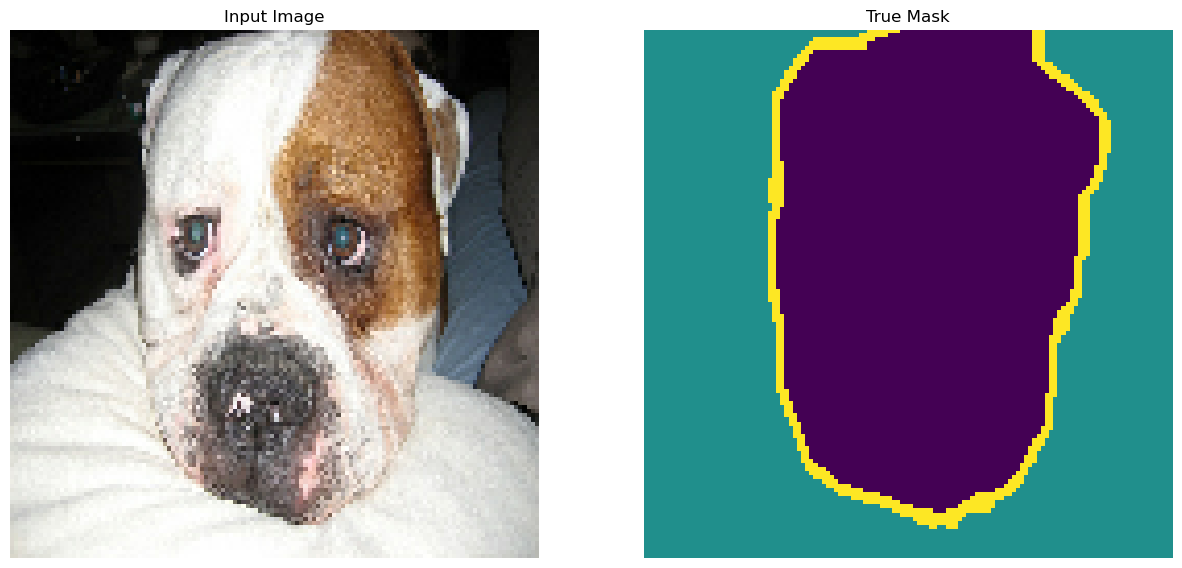

In [ ]:
def display(display_list):
 plt.figure(figsize=(15, 15))
 title = ["Input Image", "True Mask", "Predicted Mask"]
 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()
sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

In [ ]:
def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

In [ ]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

In [ ]:
def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x

In [ ]:
 def build_unet_model():
   inputs = layers.Input(shape=(128,128,3))
   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 256)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 512)
   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1024)
   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64)
   # outputs
   outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)
   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
   return unet_model

In [ ]:
unet_model = build_unet_model()

In [ ]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")

In [ ]:
NUM_EPOCHS = 20
TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VAL_SUBSPLITS = 5
TEST_LENTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS
model_history = unet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=test_batches,callbacks=tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True))

Epoch 1/20


2023-04-20 12:39:17.323906: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inU-Net/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 116s 1s/step - loss: 0.9580 - accuracy: 0.5674 - val_loss: 0.8377 - val_accuracy: 0.5865
Epoch 2/20
57/57 [==============================] - 83s 1s/step - loss: 0.7490 - accuracy: 0.6772 - val_loss: 0.6781 - val_accuracy: 0.7291
Epoch 3/20
57/57 [==============================] - 70s 1s/step - loss: 0.6503 - accuracy: 0.7376 - val_loss: 0.6033 - val_accuracy: 0.7575
Epoch 4/20
57/57 [==============================] - 70s 1s/step - loss: 0.5996 - accuracy: 0.7602 - val_loss: 0.5824 - val_accuracy: 0.7703
Epoch 5/20
57/57 [==============================] - 70s 1s/step - loss: 0.5627 - accuracy: 0.7770 - val_loss: 0.5375 - val_accuracy: 0.7865
Epoch 6/20
57/57 [==============================] - 71s 1s/step - loss: 0.5044 - accuracy: 0.8019 - val_loss: 0.5090 - val_accuracy: 0.8023
Epoch 7/20
57/57 [==============================] - 70s 1s/step - loss: 0.4883 - accuracy: 0.8104 - val_loss: 0.4664 - val_accuracy: 0.8234
Epoch 8/20
57/57 [============

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]
def show_predictions(dataset=None, num=1):
  if dataset:
   for image, mask in dataset.take(num):
     pred_mask = unet_model.predict(image)
     display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
            create_mask(model.predict(sample_image[tf.newaxis, ...]))])
count = 0
for i in test_batches:
   count +=1
print("number of batches:", count)

number of batches: 11


2/2 [==============================] - 1s 10ms/step


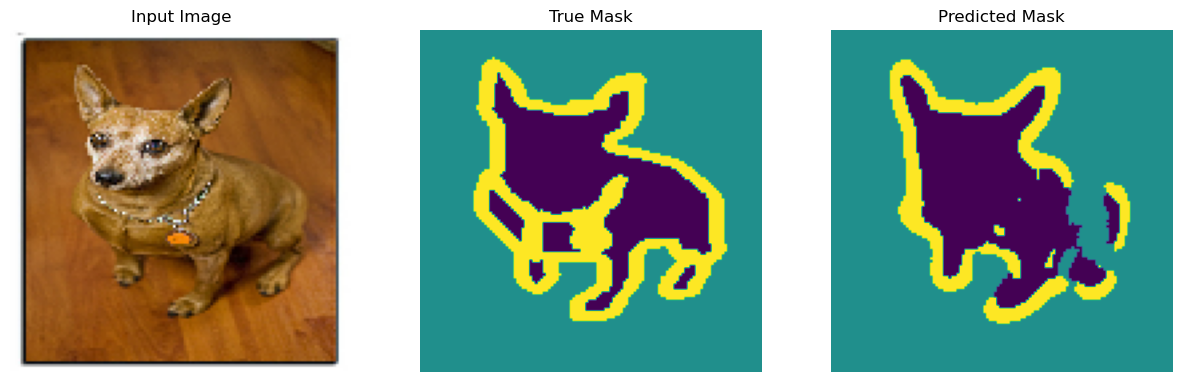

2/2 [==============================] - 0s 136ms/step


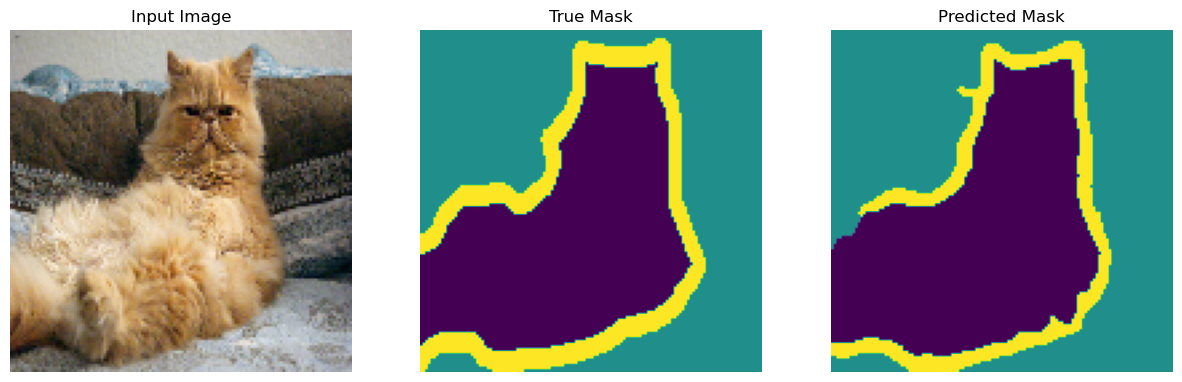

2/2 [==============================] - 0s 132ms/step


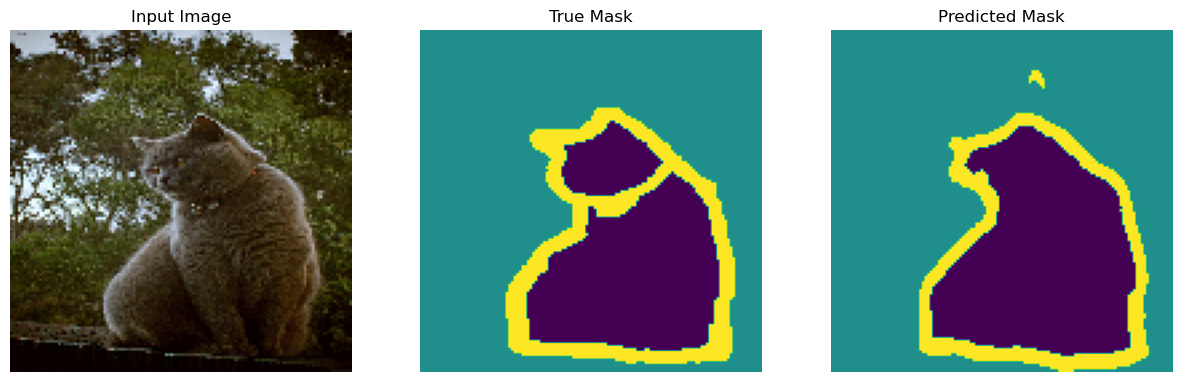

2/2 [==============================] - 0s 137ms/step


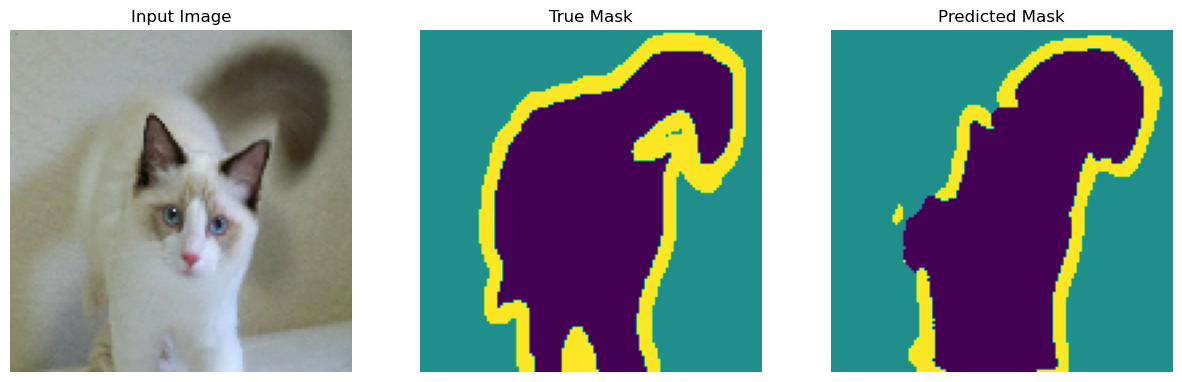

2/2 [==============================] - 0s 138ms/step


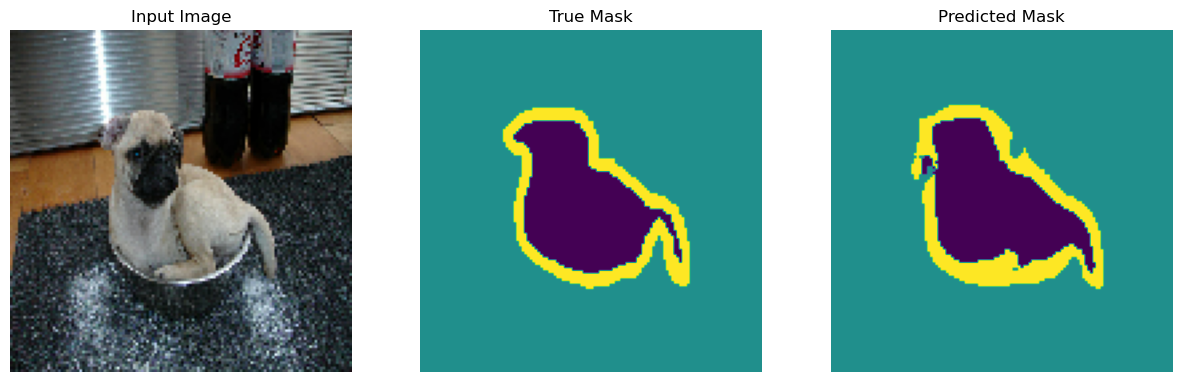

2/2 [==============================] - 0s 130ms/step


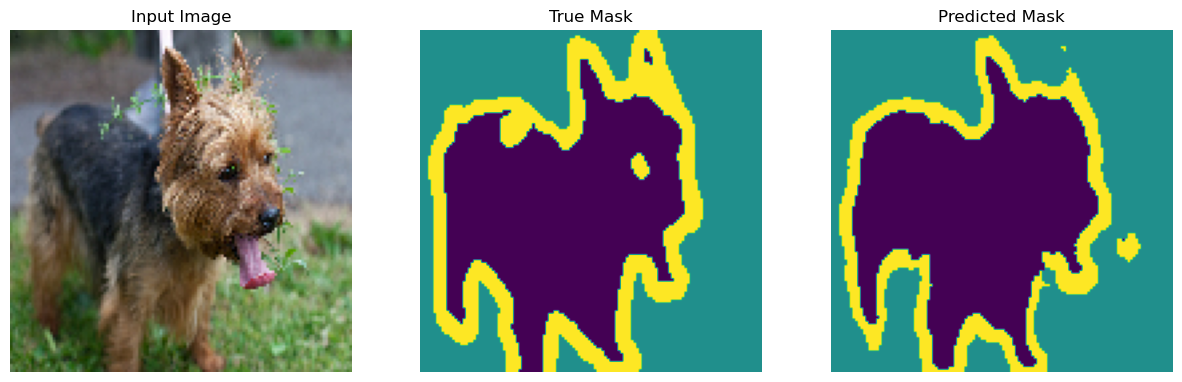

In [ ]:
show_predictions(test_batches, 6)

#Using VGG-16 as pretrained model on CIFAR-10

In [ ]:
# Importing necessary libraries
import numpy as np
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten



In [ ]:
# Load CIFAR10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


170498071/170498071 [==============================] - 36s 0us/step


In [ ]:
# Normalize pixel values to be between 0 and 1
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [ ]:
# Convert class vectors to binary class matrices
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [ ]:
# Load pre-trained VGG16 model and remove last layer
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
model = Sequential()
for layer in vgg_model.layers:
    model.add(layer)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
# Freeze pre-trained layers
for layer in model.layers[:-2]:
    layer.trainable = False

In [ ]:
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Fit model
model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_test, y_test), verbose=1)

Epoch 1/10
391/391 [==============================] - 808s 2s/step - loss: 1.4058 - accuracy: 0.5105 - val_loss: 1.2578 - val_accuracy: 0.5601
Epoch 2/10
391/391 [==============================] - 744s 2s/step - loss: 1.2006 - accuracy: 0.5817 - val_loss: 1.2158 - val_accuracy: 0.5750
Epoch 3/10
391/391 [==============================] - 733s 2s/step - loss: 1.1414 - accuracy: 0.6025 - val_loss: 1.1751 - val_accuracy: 0.5847
Epoch 4/10
391/391 [==============================] - 729s 2s/step - loss: 1.1003 - accuracy: 0.6173 - val_loss: 1.1523 - val_accuracy: 0.5936
Epoch 5/10
391/391 [==============================] - 728s 2s/step - loss: 1.0670 - accuracy: 0.6272 - val_loss: 1.1355 - val_accuracy: 0.5952
Epoch 6/10
391/391 [==============================] - 726s 2s/step - loss: 1.0325 - accuracy: 0.6397 - val_loss: 1.1285 - val_accuracy: 0.6113
Epoch 7/10
391/391 [==============================] - 726s 2s/step - loss: 1.0101 - accuracy: 0.6486 - val_loss: 1.1224 - val_accuracy: 0.6090

In [ ]:
# Evaluate model
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.1067396402359009
Test accuracy: 0.6187000274658203


#Using ResNet-50 pretatrained model on cifar-10

In [ ]:
# Importing necessary libraries
import numpy as np
from keras.datasets import cifar10
from keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.models import Model

In [ ]:
# Load CIFAR10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [ ]:
# Normalize pixel values to be between 0 and 1
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [ ]:
# Convert class vectors to binary class matrices
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [ ]:
# Load pre-trained ResNet50 model and remove last layer
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
x = resnet_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=resnet_model.input, outputs=predictions)

In [ ]:
# Freeze pre-trained layers
for layer in model.layers[:-2]:
    layer.trainable = False

In [ ]:
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Fit model
model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_test, y_test), verbose=1)

Epoch 1/10
391/391 [==============================] - 246s 618ms/step - loss: 2.0883 - accuracy: 0.2400 - val_loss: 1.9516 - val_accuracy: 0.2634
Epoch 2/10
391/391 [==============================] - 244s 625ms/step - loss: 1.9018 - accuracy: 0.3099 - val_loss: 1.8451 - val_accuracy: 0.3404
Epoch 3/10
391/391 [==============================] - 238s 607ms/step - loss: 1.8449 - accuracy: 0.3324 - val_loss: 1.7734 - val_accuracy: 0.3721
Epoch 4/10
391/391 [==============================] - 237s 606ms/step - loss: 1.8018 - accuracy: 0.3525 - val_loss: 1.7628 - val_accuracy: 0.3724
Epoch 5/10
391/391 [==============================] - 237s 607ms/step - loss: 1.7719 - accuracy: 0.3613 - val_loss: 1.7924 - val_accuracy: 0.3505
Epoch 6/10
391/391 [==============================] - 235s 602ms/step - loss: 1.7510 - accuracy: 0.3721 - val_loss: 1.7479 - val_accuracy: 0.3737
Epoch 7/10
391/391 [==============================] - 238s 609ms/step - loss: 1.7239 - accuracy: 0.3826 - val_loss: 1.6878 -

In [ ]:
# Evaluate model
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.7246814966201782
Test accuracy: 0.3750999867916107


#cifar with DenseNet121 :


In [ ]:
import numpy as np
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.applications.densenet import DenseNet121
from keras.models import Sequential
from keras.layers import Dense, Flatten

In [ ]:
# Load CIFAR10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 14s 0us/step


In [ ]:
# Normalize pixel values to be between 0 and 1
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [ ]:
# Convert class vectors to binary class matrices
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [ ]:
# Load pre-trained DenseNet121 model and remove last layer
densenet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
x = densenet_model.output
x = Flatten()(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Sequential()
model.add(densenet_model)
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
# Freeze pre-trained layers
for layer in densenet_model.layers:
    layer.trainable = False

In [ ]:
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Fit model
model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_test, y_test), verbose=1)

Epoch 1/10
391/391 [==============================] - 217s 534ms/step - loss: 1.4499 - accuracy: 0.4983 - val_loss: 1.1960 - val_accuracy: 0.5864
Epoch 2/10
391/391 [==============================] - 205s 526ms/step - loss: 1.1464 - accuracy: 0.6048 - val_loss: 1.1179 - val_accuracy: 0.6114
Epoch 3/10
391/391 [==============================] - 203s 521ms/step - loss: 1.0822 - accuracy: 0.6266 - val_loss: 1.0942 - val_accuracy: 0.6185
Epoch 4/10
391/391 [==============================] - 218s 558ms/step - loss: 1.0521 - accuracy: 0.6351 - val_loss: 1.0765 - val_accuracy: 0.6270
Epoch 5/10
391/391 [==============================] - 208s 532ms/step - loss: 1.0350 - accuracy: 0.6405 - val_loss: 1.0632 - val_accuracy: 0.6296
Epoch 6/10
391/391 [==============================] - 203s 521ms/step - loss: 1.0214 - accuracy: 0.6476 - val_loss: 1.0578 - val_accuracy: 0.6334
Epoch 7/10
391/391 [==============================] - 205s 523ms/step - loss: 1.0110 - accuracy: 0.6479 - val_loss: 1.0565 -

In [ ]:
# Evaluate model
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.056918740272522
Test accuracy: 0.635200023651123
